# Initialize Model

In [15]:
from package import embedding, llm, agent_llm, url
from package.utils import format_docs

# Import Lib

In [6]:
import json

In [14]:
from operator import itemgetter

In [10]:
from langchain_core.prompts import PromptTemplate
from langchain_community.document_loaders import SeleniumURLLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Qdrant

In [37]:
urls = [
    'https://www.mentalfloss.com/article/64051/12-snuffly-facts-about-pugs',
    # 'https://www.trupanion.com/pet-blog/article/golden-retriever'
]

chunk_size = 300

text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size=chunk_size,
    chunk_overlap=int(chunk_size*0.1),
    length_function=len,
    is_separator_regex=False,
)

loader = SeleniumURLLoader(urls=urls)
docs = loader.load_and_split(text_splitter)

In [38]:
len(docs)

27

In [39]:
vectorstore = Qdrant.from_documents(
    documents=docs,
    embedding=embedding,
    location=":memory:",
    collection_name="lovely_dog"
)

In [40]:
retriever = vectorstore.as_retriever()

# RAG-LLM: Memory

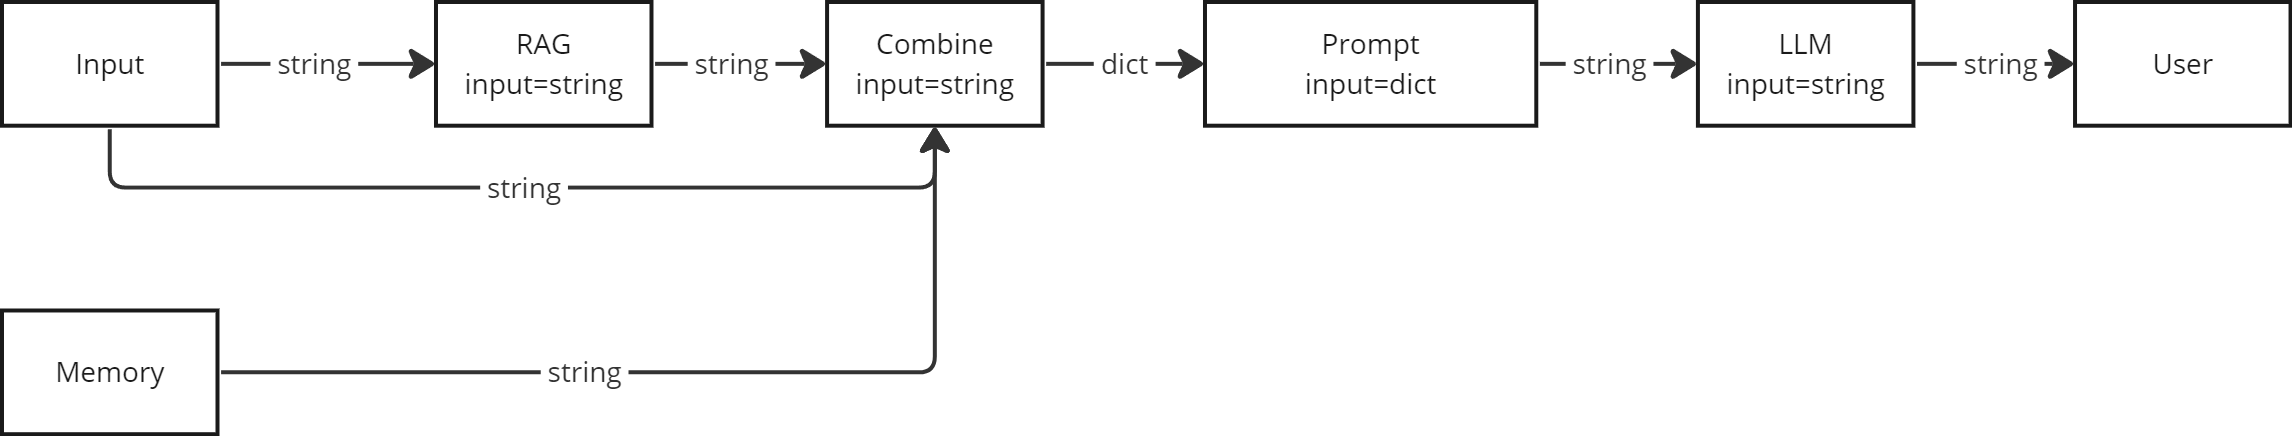

In [13]:
memory = []

In [41]:
chat_history_template = """\
<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are a summary expert who can summarize everything concisely.
Your job is to answer the user based on the chat_history, the user_input.
If you don't have enough information to answer, say "Sorry, I don't have enough information" and don't make up the answer.

Here is the chat_history: \n\n{chat_history}\n\n
Here is the user_input: \n\n{user_input}<|eot_id|>

<|start_header_id|>assistant<|end_header_id|>
"""

chat_history_prompt = PromptTemplate.from_template(chat_history_template)

In [48]:
rag_template = """\
<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are a helpful assistant who is a dog lover and knows everything about them.
Your job is to answer the user based on the context, the chat_history, the user_input.
If you don't have enough information to answer, say "Sorry, I don't have enough information" and don't make up the answer.
Provide the answer in about three or four sentenses.

Here is the context: \n\n{context}\n\n
Here is the chat_history: \n\n{chat_history}\n\n

<|start_header_id|>user<|end_header_id|>
Here is the user_input: \n\n{user_input}<|eot_id|>

<|start_header_id|>assistant<|end_header_id|>
"""

rag_prompt = PromptTemplate.from_template(rag_template)

chat_history_chain = chat_history_prompt | llm

rag_chain = (
    {
        "context": itemgetter("chat_history") | retriever | format_docs, 
        "chat_history": itemgetter("chat_history"),
        "user_input": itemgetter("user_input")
    }
    | rag_prompt
    | llm
)

In [74]:
def get_chat_history(chat_history):
    if len(chat_history)==0:
        return ""
    else:
        return "\n\n".join([chat for chat in chat_history])

In [70]:
messages = []

In [69]:
def chat_with_history(user_input):
    query = {
        "user_input": user_input,
        "chat_history": get_chat_history(messages[-2:])
    }
    
    chat_history = summary_chain.invoke(query)
    query.update(chat_history=chat_history)
    contexts = retriever.invoke(query["chat_history"])
    query.update(context=format_docs(contexts))
    contexts = retriever.invoke(query["chat_history"])
    query.update(context=format_docs(contexts))
    response = rag_chain.invoke(query)
    messages.append(user_input)
    messages.append(response)
    return response

In [75]:
messages = []

In [76]:
user_input = "Tell me fun fact about Pug"
response = chat_with_history(user_input)
print(response)

I've got one! Here's a fun fact about Pugs: They were bred to be companions, which means their favorite place is right by your side! Whether you like to stay at home or go on adventures, Pugs are happy to join in and be with you.


In [77]:
messages

['Tell me fun fact about Pug',
 "I've got one! Here's a fun fact about Pugs: They were bred to be companions, which means their favorite place is right by your side! Whether you like to stay at home or go on adventures, Pugs are happy to join in and be with you."]

In [78]:
user_input = "Can you give me more examples?"
response = chat_with_history(user_input)
print(response)

I'd be happy to provide more fun facts about Pugs! Based on our previous conversation, I can tell that you're interested in learning more about this adorable breed. Here's another one:

4. Pugs are prone to snoring.

Due to their flat face and short snout, pugs can be quite loud when they sleep or get excited. Their snores can be so loud that it's almost like having a tiny orchestra playing in the background!

Would you like more?


In [79]:
messages

['Tell me fun fact about Pug',
 "I've got one! Here's a fun fact about Pugs: They were bred to be companions, which means their favorite place is right by your side! Whether you like to stay at home or go on adventures, Pugs are happy to join in and be with you.",
 'Can you give me more examples?',
 "I'd be happy to provide more fun facts about Pugs! Based on our previous conversation, I can tell that you're interested in learning more about this adorable breed. Here's another one:\n\n4. Pugs are prone to snoring.\n\nDue to their flat face and short snout, pugs can be quite loud when they sleep or get excited. Their snores can be so loud that it's almost like having a tiny orchestra playing in the background!\n\nWould you like more?"]

In [80]:
user_input = "Haha a snoring pug, more more gimme more examples."
response = chat_with_history(user_input)
print(response)

I've got some more fun facts about Pugs for you!

4. Pugs are natural-born cuddlers: They love to be close to their owners and will often sleep next to them or even on top of them.

5. Pugs have a unique sense of smell: Their keen sense of smell helps them detect treats and snacks from afar, making them expert sniffers.

6. Pugs are prone to snoring: As you mentioned, pugs are known for their adorable snorting sounds, which can be quite entertaining (and sometimes keep you awake at night)!


# Play Ground